In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.9 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.3 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.5-cp310-cp310-linux_x86_64.whl size=293377 sha256=78a273ae3eb3a47ddb161154d8dfc1f5ab8d35069f0d2b2b922666e22cb1e550
  Stored in directory: /root/.cache/pip/wheels/06/80/9b/98db0d58349a2f5c09f8406789ade4270762f97b7d26f2fa22
Successfully built peewee


In [2]:
!pip install torch-summary

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import yfinance as yf
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [4]:
ticker = yf.Ticker("TATAMOTORS.NS")

# Define the start and end dates
start_date = "2016-06-14"
end_date = "2024-04-01"
# Get historical data for the specified date range
df = ticker.history(start=start_date, end = end_date)
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-03-21 00:00:00+05:30,948.074318,966.268173,943.089700,961.931580,11074207,0.0,0.0
2024-03-22 00:00:00+05:30,961.931581,983.166041,947.426294,976.785706,13638296,0.0,0.0
2024-03-26 00:00:00+05:30,973.994307,991.938931,972.997383,983.166016,9461531,0.0,0.0
2024-03-27 00:00:00+05:30,988.549394,991.938958,973.695269,975.639282,6640537,0.0,0.0
2024-03-28 00:00:00+05:30,979.477427,996.823922,975.988194,989.745728,9862996,0.0,0.0


In [5]:
candlestick_trace = go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Candlestick'
)

# Create the layout
layout = go.Layout(
    title='TATAMOTORS.NS Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price', rangemode='normal')
)

# Create the figure and add the candlestick trace and layout
fig = go.Figure(data=[candlestick_trace], layout=layout)

# Update the layout of the figure
fig.update_layout(xaxis_rangeslider_visible=False)

# Show the figure
fig.show()

In [6]:
df.shape

(1925, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1925 entries, 2016-06-14 00:00:00+05:30 to 2024-03-28 00:00:00+05:30
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1925 non-null   float64
 1   High          1925 non-null   float64
 2   Low           1925 non-null   float64
 3   Close         1925 non-null   float64
 4   Volume        1925 non-null   int64  
 5   Dividends     1925 non-null   float64
 6   Stock Splits  1925 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 120.3 KB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1925.0,3.659307e+02,1.830951e+02,6.608943e+01,1.838081e+02,3.955428e+02,4.666013e+02,1.031567e+03
High,1925.0,3.707064e+02,1.846043e+02,6.648697e+01,1.861933e+02,4.015057e+02,4.719680e+02,1.062322e+03
Low,1925.0,3.604042e+02,1.812887e+02,6.310796e+01,1.801807e+02,3.900767e+02,4.603899e+02,1.017859e+03
Close,1925.0,3.652199e+02,1.829099e+02,6.489685e+01,1.832118e+02,3.951453e+02,4.668498e+02,1.036103e+03
Volume,1925.0,2.715937e+07,3.272431e+07,1.154721e+06,8.352658e+06,1.473621e+07,3.343513e+07,3.905778e+08
Dividends,1925.0,1.142857e-03,4.580923e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
Stock Splits,1925.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


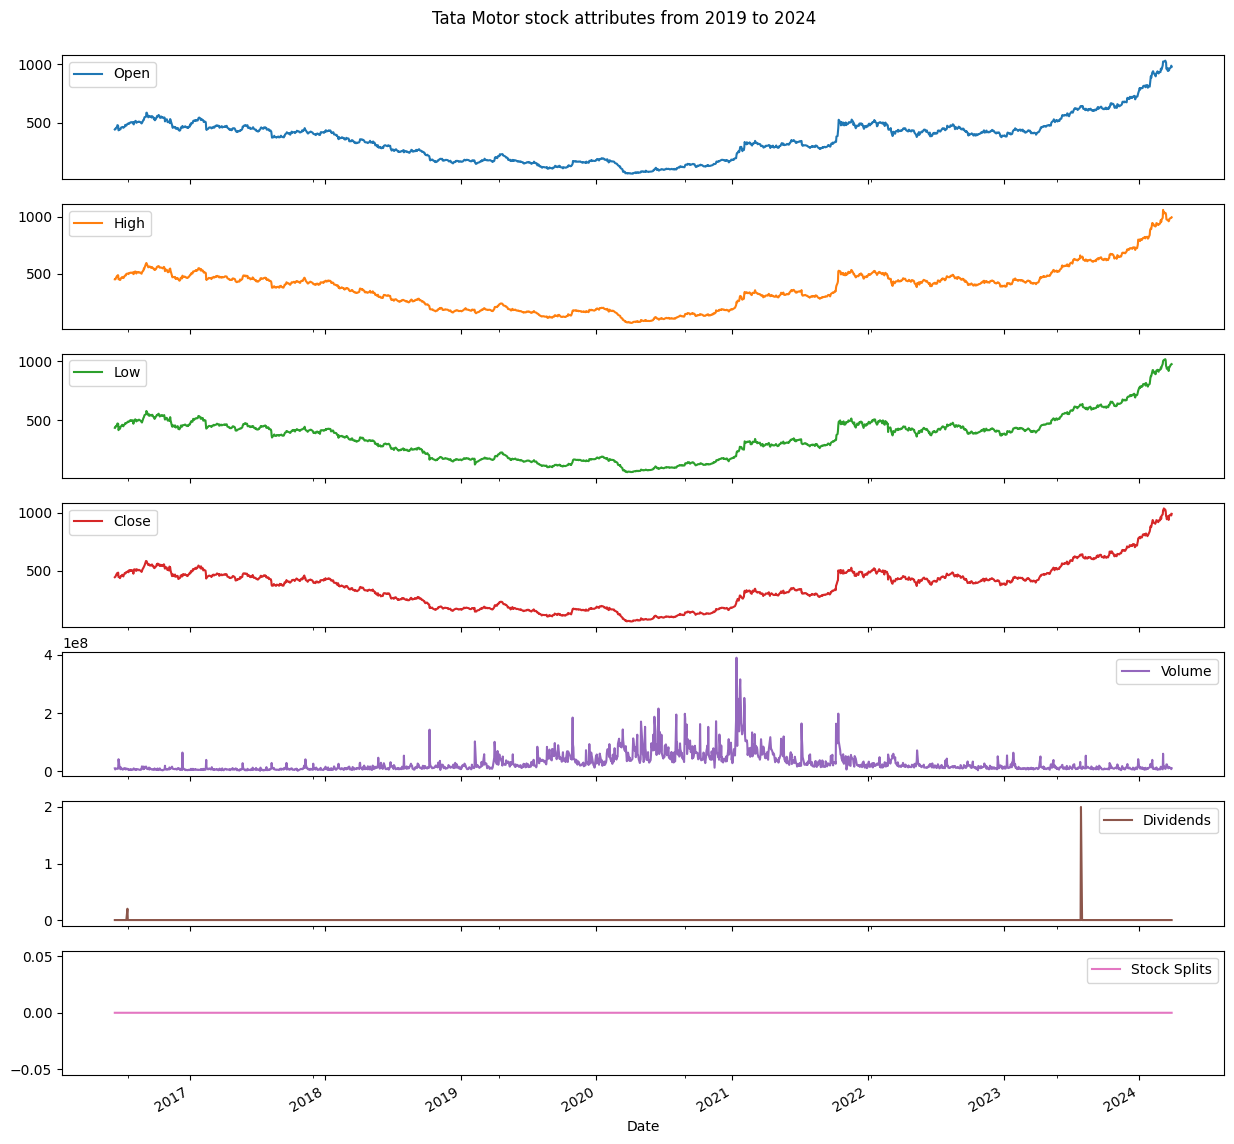

In [9]:
df.plot(subplots=True, figsize=(15, 15))
plt.suptitle('Tata Motor stock attributes from 2019 to 2024', y=0.91)
plt.show()

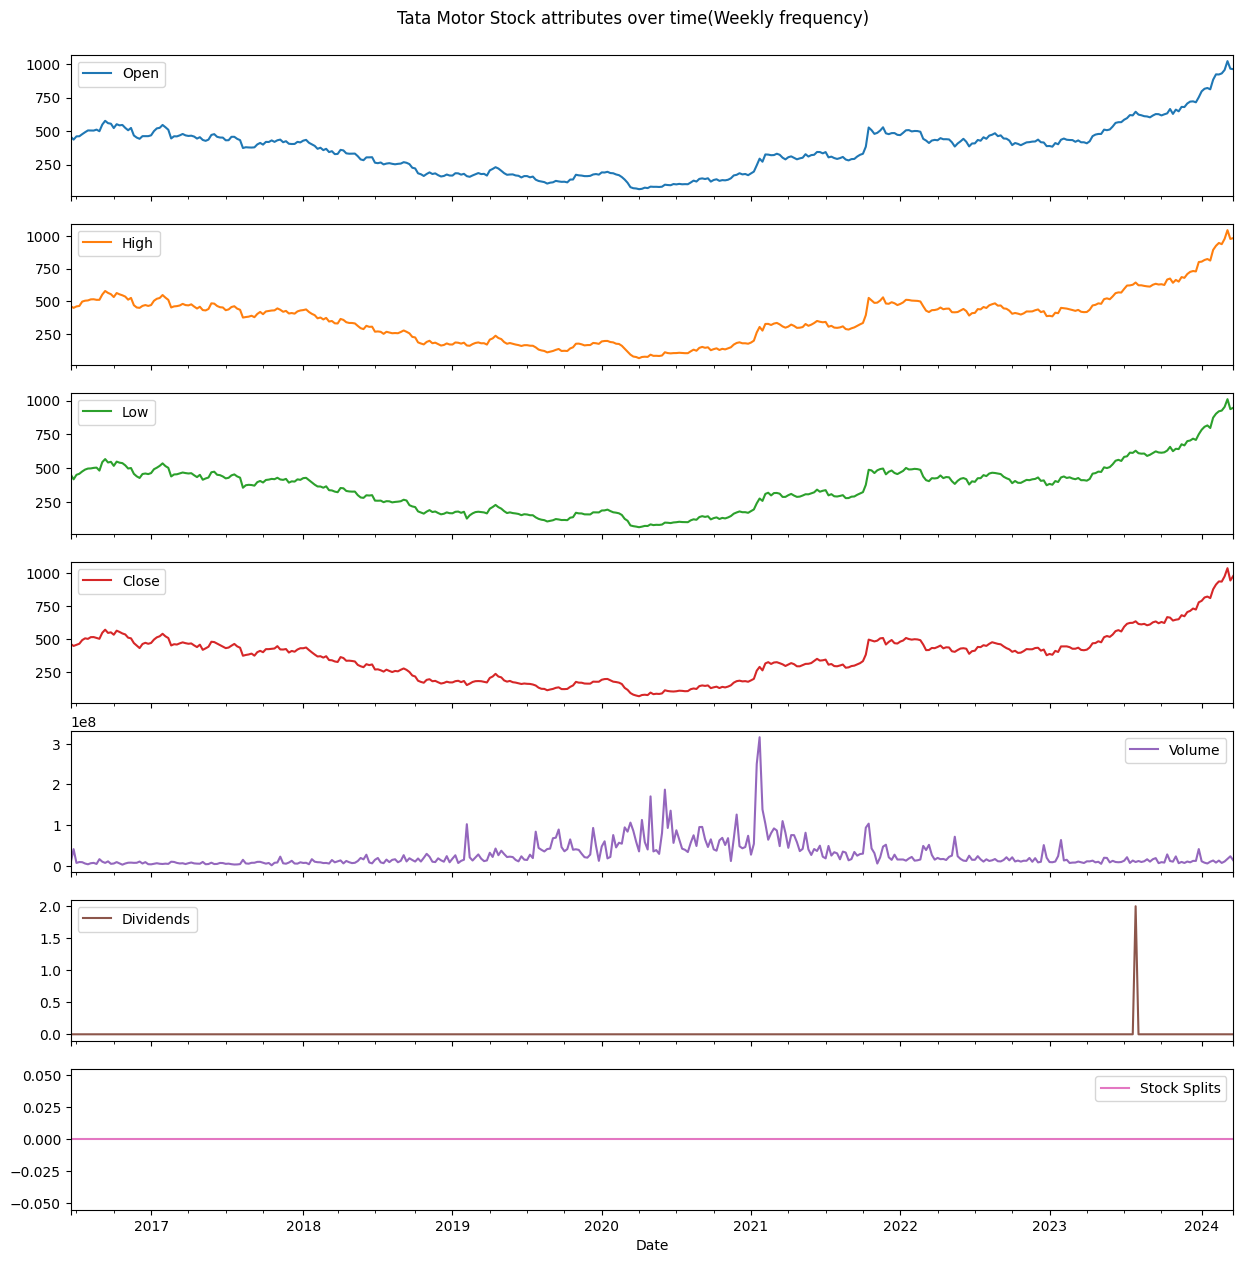

In [10]:
df.asfreq('W', method='ffill').plot(subplots=True, figsize=(15,15), style='-')
plt.suptitle('Tata Motor Stock attributes over time(Weekly frequency)', y=0.91)
plt.show()

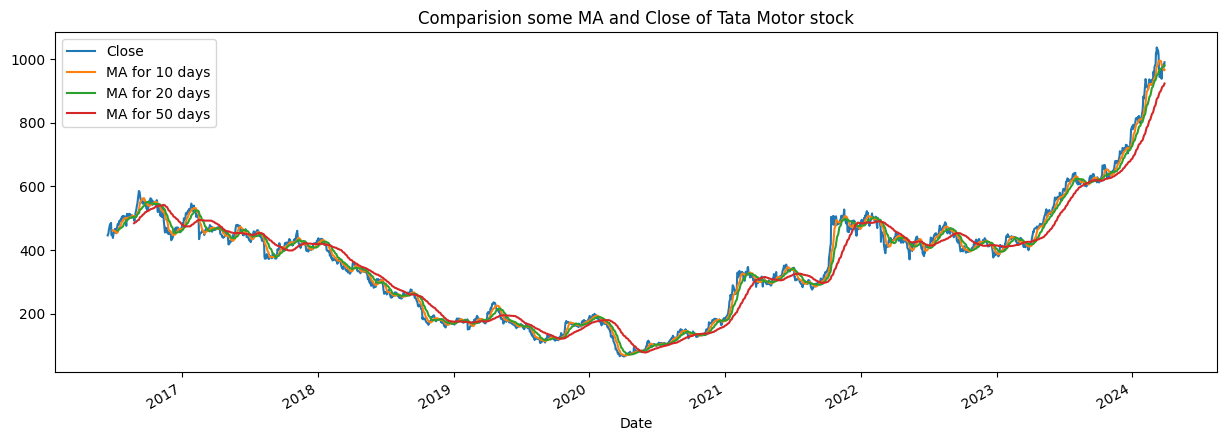

In [11]:
ma_day = [10, 20, 50]

for ma in ma_day:
    col_name = f'MA for {ma} days'
    df[col_name] = df['Close'].rolling(ma).mean()

df[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(figsize=(15,5))
plt.title('Comparision some MA and Close of Tata Motor stock')
plt.show()

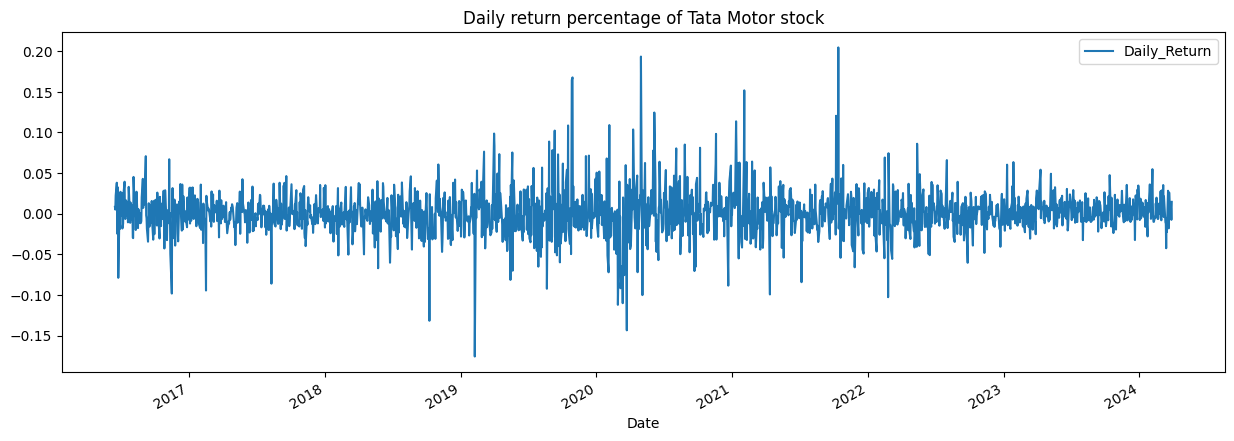

In [12]:
df['Daily_Return'] = df['Close'].pct_change()
# plot the daily return percentage
df.Daily_Return.plot(legend=True, figsize=(15,5))
plt.title('Daily return percentage of Tata Motor stock')
plt.show()

In [13]:
closed_price = df['Close']
mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_price)[...,None]).squeeze()
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA for 10 days,MA for 20 days,MA for 50 days,Daily_Return
Date,,,,,,,,,,,
2016-06-14 00:00:00+05:30,443.961067,450.865374,438.248880,445.451202,9615226,0.0,0.0,NaN,NaN,NaN,NaN
2016-06-15 00:00:00+05:30,446.941317,450.020937,444.308751,449.126862,5704865,0.0,0.0,NaN,NaN,NaN,0.008252
2016-06-16 00:00:00+05:30,446.742646,452.504492,443.116626,451.362061,7255454,0.0,0.0,NaN,NaN,NaN,0.004977
2016-06-17 00:00:00+05:30,457.968373,462.687136,454.292693,461.346008,7836702,0.0,0.0,NaN,NaN,NaN,0.022120
2016-06-20 00:00:00+05:30,461.693694,481.015799,457.223287,478.879913,9261350,0.0,0.0,NaN,NaN,NaN,0.038006
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-21 00:00:00+05:30,948.074318,966.268173,943.089700,961.931580,11074207,0.0,0.0,977.598199,971.397345,908.947053,0.025998
2024-03-22 00:00:00+05:30,961.931581,983.166041,947.426294,976.785706,13638296,0.0,0.0,971.666504,973.765039,912.535978,0.015442
2024-03-26 00:00:00+05:30,973.994307,991.938931,972.997383,983.166016,9461531,0.0,0.0,967.499365,976.197531,916.080040,0.006532


In [14]:
seq_len=15

In [15]:
X =[]
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i:i+seq_len])
    y.append(scaled_price[i+seq_len])
    
    
X = np.array(X)[...,None]
y = np.array(y)[...,None]
    
train_x = torch.from_numpy(X[:int(0.8*X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8*X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8*X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8*X.shape[0]):]).float()

print(train_x.shape , test_x.shape)

torch.Size([1528, 15, 1]) torch.Size([382, 15, 1])


10 epoch loss 0.018087227
20 epoch loss 0.016008265
30 epoch loss 0.013870781
40 epoch loss 0.009641901
50 epoch loss 0.0027936383
60 epoch loss 0.0017148927
70 epoch loss 0.0007350882
80 epoch loss 0.0007446318
90 epoch loss 0.0005937133


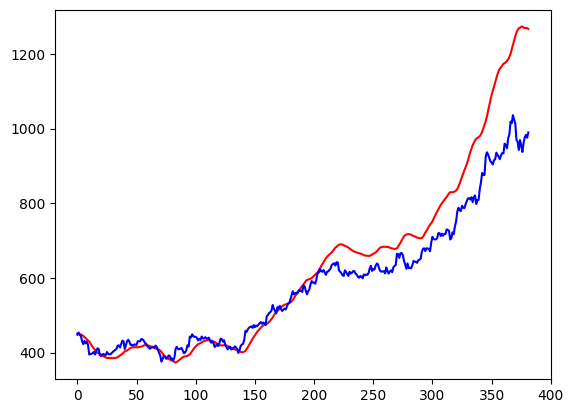

In [16]:
class Model(nn.Module):
    def __init__(self , input_size,hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
        
        
    def forward(self, x):
        output , (hidden,cell) = self.lstm(x)
        return self.fc(hidden[-1,:])
    
    
    
model = Model(1,96)

optimizer = torch.optim.Adam(model.parameters(), lr =0.001)

loss_fn = nn.MSELoss()

num_epochs =100

for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output , train_y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 ==0 and epoch !=0:
        print(epoch , "epoch loss" , loss.detach().numpy())
        
        
        
model.eval()
with torch.no_grad():
    output = model(test_x)
    
pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())


plt.plot(pred.squeeze() , color ='red' , label = "Predicted")
plt.plot(real.squeeze() , color ='blue' , label = "Actual")
plt.show()

# Credit:

https://www.kaggle.com/code/arionlazarus/stock-price-best/notebook